# Model 3: Consumer Loan Fees

**Imports:**

In [1]:
%reload_ext autoreload
%autoreload 1
from pprint import pprint
import polars as pl
import shap
from sklearn.pipeline import Pipeline
import auxiliary.transformers as tr
import auxiliary.eda_functions as eda
from auxiliary.transformers import PolarsColumnTransformer as PCT
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import copy
import seaborn as sns
import auxiliary.tuning as tunes
from ray import tune
import joblib
import numpy as np
import matplotlib.pyplot as plt
BASE_FIG_SIZE=(8.5,4.5)
%aimport auxiliary.eda_functions
%aimport auxiliary.transformers
%aimport auxiliary.tuning

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


**Data Imports and Splitting:**

In [2]:
data = pl.read_parquet("temp/consumer_loans.parquet")
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns="FEES_PERCENT"),
    data["FEES_PERCENT"],
    test_size=0.3,
    random_state=1,
)

## Pipeline Construction

**Specifying feature types:**

In [3]:
cat_features = [feature for feature in X_train.select(pl.col(pl.Utf8)).columns]

numeric_features_with_nulls = (
    pl.Series(
        X_train.select(pl.col(pl.FLOAT_DTYPES), pl.col(pl.INTEGER_DTYPES)).columns
    )
    .filter(
        X_train.select(pl.col(pl.FLOAT_DTYPES), pl.col(pl.INTEGER_DTYPES))
        .select(pl.all().is_null().any())
        .transpose()
        .to_series()
    )
    .to_list()
)

**Which Numeric Features Have Missing Values?**

In [4]:
numeric_features_with_nulls

['AMT_DOWN_PAYMENT', 'RATE_DOWN_PAYMENT', 'NFLAG_INSURED_ON_APPROVAL']

From a common sense perspective, a missing value in down payment or the flag "whether the loan was insured" is considered equal to 0. Therefore, these values will be imputed as 0. Missing values in categorical features will be treated as separate categories and encoded using either label or one-hot encoding. 

### Preprocessing Pipeline

**Lienar Models:**

In [5]:
preprocessing = Pipeline([])

cat_imputers = tr.PolarsColumnTransformer(
    [
        PCT.Step(
            "goods_filter",
            tr.NotInImputerPolars(min_values=300, fill_value="Other"),
            "NAME_GOODS_CATEGORY",
        )
    ]
)

preprocessing.steps.append(("cat_imputers", cat_imputers))

encoders = tr.PolarsColumnTransformer([])

for feature in cat_features:
    encoders.steps[feature] = PCT.Step(feature, tr.PolarsOneHotEncoder(), feature)

preprocessing.steps.append(("encoders", encoders))

preprocessing.steps.append(("null_imputer", tr.PolarsNullImputer(0)))

scaler = tr.PolarsColumnTransformer(
    [
        PCT.Step(
            "scaler",
            StandardScaler(),
            preprocessing.fit_transform(X_train, y_train).columns,
        )
    ]
)

preprocessing.steps.append(("scaler", scaler))

For linear models, the preprocessing involved pooling minority classes with fewer than 300 items into "Other" for categoricals. Categorical features were then one-hot encoded. Imputation of the three numeric features was done using 0, and standard scaling was applied to these numeric features.

**Decision Tree:**

In [6]:
preprocessing_tree = Pipeline([])

cat_imputers_tree = tr.PolarsColumnTransformer(
    [
        PCT.Step(
            "goods_filter",
            tr.NotInImputerPolars(min_values=300, fill_value="Other"),
            "NAME_GOODS_CATEGORY",
        )
    ]
)

preprocessing_tree.steps.append(("cat_imputers", cat_imputers_tree))

encoders_tree = tr.PolarsColumnTransformer([])

for feature in cat_features:
    encoders_tree.steps[feature] = PCT.Step(
        feature, tr.TargetMeanOrderedLabeler(how="label"), feature
    )

preprocessing_tree.steps.append(("encoders", encoders_tree))

preprocessing_tree.steps.append(("null_imputer", tr.PolarsNullImputer(0)))

The decision tree pipeline differed in that, instead of one-hot encoding, it employed label encoding with labels ordered by the target mean. Additionally, the scaler was removed from the preprocessing steps. 

**Models:**

As this is a prototype of a loan pricing model, emphasis is placed on simplicity and interpretability. Therefore, only the most straightforward models, such as Linear Regression with either Lasso or Ridge regularization and a simple Decision Tree, will be tested. This choice prioritizes transparency and ease of understanding in the pricing model.

In [7]:
model_ridge = Ridge(random_state=1)
full_pipeline_ridge = Pipeline([("preprocess", preprocessing), ("model", model_ridge)])

model_lasso = Lasso(random_state=1)
full_pipeline_lasso = Pipeline(
    [("preprocess", copy.deepcopy(preprocessing)), ("model", model_lasso)]
)

model_tree = DecisionTreeRegressor(random_state=1)
full_pipeline_tree = Pipeline(
    [("preprocess", preprocessing_tree), ("model", model_tree)]
)

## Feature Selection

## Hyperparameter Tuning

In [8]:
models = tunes.Models()

**Hyperparameter search space linear models:**

In [9]:
search_space_lr = {
    "model__alpha": tune.loguniform(0.0001, 100),
}

models.add_model("Ridge", full_pipeline_ridge, search_space_lr, metric_threshold=-13)

models.add_model("Lasso", full_pipeline_lasso, search_space_lr, metric_threshold=-13)

**Hyperparameter search space decision tree model:**

In [10]:
search_space_tree = {
    "model__max_depth": tune.randint(1, 15),
    "model__min_samples_split": tune.randint(2, 200),
}

models.add_model(
    "Decision_Tree",
    full_pipeline_tree,
    search_space_tree,
    metric_threshold=-13,
    override_n=100,
)

In the hyperparameter tuning phase for linear models, only the regularization parameter was varied. For the decision tree, tree depth and minimum samples for a leaf split were the parameters subjected to variation.

**Hyperparameter tuning:**

In [11]:
models = joblib.load("temp/model_3_tuned_model.joblib")

The hyperparameter tuning process utilized the Ray-Tune library and the Optuna algorithm. Sets of parameters were evaluated through a 5-fold cross-validation, with the metric of choice being root mean squared error (RMSE). This rigorous evaluation method ensures that the selected parameters enhance the model's predictive performance on the given dataset.

**Best Parameters:**

In [12]:
for model in models.models.values():
    print(model.name)
    for key, param in model.best_params.items():
        pprint(key + ":")
        pprint(param)
    print("\n")

Ridge
'model__alpha:'
93.45287555779794


Lasso
'model__alpha:'
0.0017873631376742007


Decision_Tree
'model__max_depth:'
14
'model__min_samples_split:'
37




## Model Selection

#### Cross-Validation

**Cross-validate all models:**

In [14]:
rmse_all = {}
for key, model in models.models.items():
    rmse_all[key] = model.cross_val_mse(X_train, y_train, squared=False)
rmse_all = pl.DataFrame(rmse_all)
joblib.dump(rmse_all, "summary_data/rmse_model3.joblib")

['summary_data/rmse_model3.joblib']

**Plot the RMSE of all tested models:**

FixedFormatter should only be used together with FixedLocator


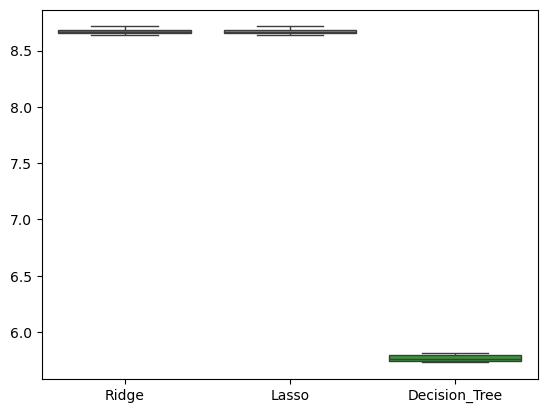

In [14]:
fig_scores, ax_scores = plt.subplots()
sns.boxplot(rmse_all)
ax_scores.set_xticklabels(rmse_all.columns)
plt.show()

The decision tree significantly outperformed linear regression models.

#### Feature Importance

It's intriguing to explore whether the decision tree and the linear models relied on different features. To investigate this, a comparison will be made between the beta coefficients of the linear ridge regression model and the feature importances of the decision tree.

In [15]:
feature_imp_tree = pl.DataFrame(
    {
        "imp": model.pipeline["model"].feature_importances_,
        "feature": model.pipeline["preprocess"].transform(X_train).columns,
    }
).sort("imp", descending=True)

beta_coeff_ridge = (
    pl.DataFrame(
        {
            "imp": models.models["Ridge"].pipeline["model"].coef_,
            "feature": models.models["Ridge"]
            .pipeline["preprocess"]
            .transform(X_train)
            .columns,
        }
    )
    .sort("imp", descending=True)
    .with_columns(pl.col("imp").abs().alias("imp"))
)

In [16]:
eda.table_display(feature_imp_tree[:10])

|        imp | feature                   |
|-----------:|:--------------------------|
| 0.40634    | CNT_PAYMENT               |
| 0.258986   | PRODUCT_COMBINATION       |
| 0.11601    | NAME_GOODS_CATEGORY       |
| 0.0590665  | AMT_APPLICATION           |
| 0.0530444  | AMT_ANNUITY               |
| 0.047562   | RATE_DOWN_PAYMENT         |
| 0.0237765  | NAME_SELLER_INDUSTRY      |
| 0.0166423  | NAME_TYPE_SUITE           |
| 0.00704226 | AMT_DOWN_PAYMENT          |
| 0.00457401 | NFLAG_INSURED_ON_APPROVAL |

In [17]:
eda.table_display(beta_coeff_ridge[:10])

|      imp | feature                                         |
|---------:|:------------------------------------------------|
| 8.87794  | CNT_PAYMENT                                     |
| 2.83576  | AMT_ANNUITY                                     |
| 2.07872  | PRODUCT_COMBINATION_POS mobile with interest    |
| 1.79406  | NAME_GOODS_CATEGORY_Mobile                      |
| 1.76448  | NAME_SELLER_INDUSTRY_Connectivity               |
| 1.66514  | AMT_DOWN_PAYMENT                                |
| 1.56839  | PRODUCT_COMBINATION_POS household with interest |
| 1.09629  | PRODUCT_COMBINATION_POS industry with interest  |
| 0.515785 | PRODUCT_COMBINATION_POS other with interest     |
| 0.409396 | hour_sin                                        |

The models utilize similar features, with the length of the loan, the annuity, and the type of goods being the most influential contributors. However, the linear model introduces some less intuitive features, such as the sine of the hour when the application was given. The poorer performance of linear regression could potentially be explained by the non-parametric distribution of some of these features and the model's limited ability to capture conditional information. If a linear model is to be used, a more careful examination of possible feature transformations is warranted to enhance its performance.

## Model Testing

### Performance Evaluation

**Root mean squared error on the test set:**

In [17]:
best_pipeline = models.models["Decision_Tree"].pipeline
best_pipeline.fit(X_train, y_train)
predictions = best_pipeline.predict(X_test)
print(round(mean_squared_error(y_test, predictions, squared=False), 2))

5.7


**True versus predicted plot:**

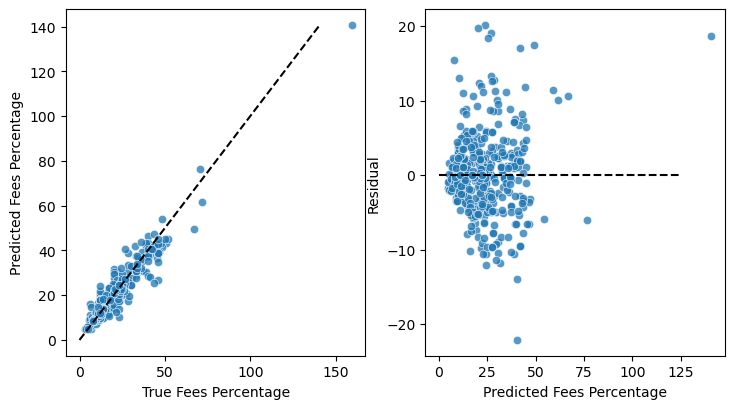

In [19]:
fig_true_pred, ax_true_pred = plt.subplots(1, 2, figsize=BASE_FIG_SIZE)
residuals = y_test - predictions
sns.scatterplot(x=y_test[:300], y=predictions[:300], ax=ax_true_pred[0], alpha=0.75)
sns.lineplot(x=[0, 140], y=[0, 140], linestyle="--", color="black", ax=ax_true_pred[0])
ax_true_pred[0].set_xlabel("True Fees Percentage")
ax_true_pred[0].set_ylabel("Predicted Fees Percentage")
sns.scatterplot(x=predictions[:500], y=residuals[:500], alpha=0.75)
sns.lineplot(x=[0, 125], y=[0, 0], linestyle="--", color="black", ax=ax_true_pred[1])
ax_true_pred[1].set_ylabel("Residual")
ax_true_pred[1].set_xlabel("Predicted Fees Percentage")
plt.show()

**Mean Residual:**

In [20]:
round(residuals.mean(), 3)

0.003

**Calculating mean residuals by loan size group:**

In [21]:
residual_amt_df = pl.DataFrame(
    [residuals.abs().alias("residuals"), X_test["AMT_APPLICATION"]]
)
residual_amt_df = residual_amt_df.with_columns(
    pl.col("AMT_APPLICATION")
    .cut(
        np.arange(10000, 110000, 10000),
        labels=[str(i) for i in np.arange(0, 110000, 10000)],
    )
    .alias("bin")
)
residuals_binned_amt = (
    residual_amt_df.group_by("bin")
    .agg(pl.col("residuals").mean())
    .sort(pl.col("bin").cast(str).cast(int))
)

**Residuals vs loan amount:**


Series.map_elements is significantly slower than the native series API.
Only use if you absolutely CANNOT implement your logic otherwise.
In this case, you can replace your `map_elements` with the following:
  - s.map_elements(lambda x: ...)
  + s + '+'



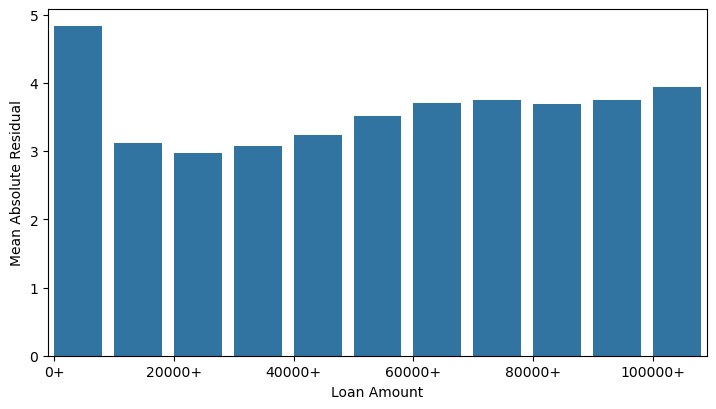

In [22]:
fig_amt_resid, ax_amt_resid = plt.subplots(figsize=BASE_FIG_SIZE)

sns.barplot(
    x=residuals_binned_amt["bin"],
    y=residuals_binned_amt["residuals"],
)
ax_amt_resid.set_xticks(np.arange(0, 12, 2) - 0.4)
ax_amt_resid.set_xticklabels(
    residuals_binned_amt["bin"].map_elements(lambda x: x + "+")[::2]
)
ax_amt_resid.set_ylabel("Mean Absolute Residual")
ax_amt_resid.set_xlabel("Loan Amount")
plt.show()

It is apparent that our model performs slightly worse for very small loans compared to others. Additionally, the performance decreases with loan size for larger loans.

### Feature Importance

In [23]:
model.pipeline["preprocess"].steps[1][1].steps["NAME_GOODS_CATEGORY"].transformer.map

{'Clothing and Accessories': 0,
 'Furniture': 1,
 'Medicine': 2,
 'Construction Materials': 3,
 'Medical Supplies': 4,
 'Consumer Electronics': 5,
 'Tourism': 6,
 'Auto Accessories': 7,
 'Homewares': 8,
 'Jewelry': 9,
 'Audio/Video': 10,
 'Gardening': 11,
 'Office Appliances': 12,
 'Computers': 13,
 'Sport and Leisure': 14,
 'Other': 15,
 'Vehicles': 16,
 'Photo / Cinema Equipment': 17,
 'Mobile': 18}

### Feature Importance

**SHAP value calculation and bee swarm plot:**

100%|===================| 187204/187940 [01:00<00:00]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


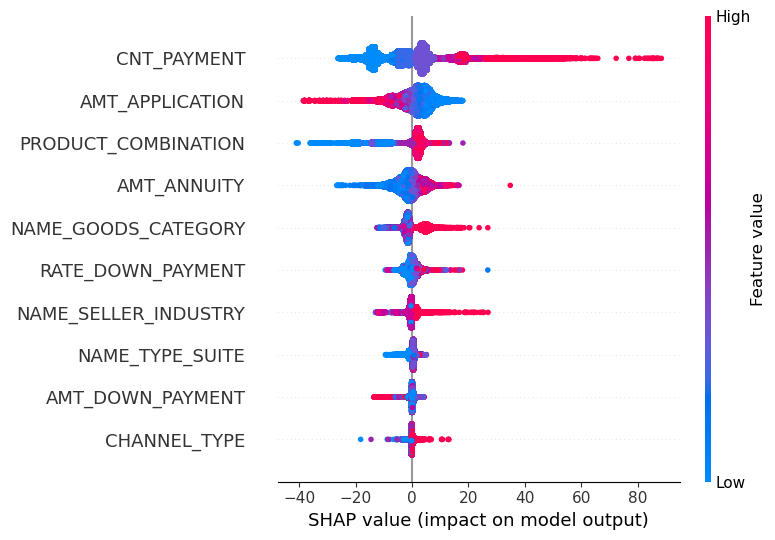

In [24]:
sample_data = best_pipeline["preprocess"].transform(X_test)

explainer_tree = shap.TreeExplainer(best_pipeline["model"], data=sample_data.to_numpy())

shap_values = explainer_tree(sample_data.to_numpy())

shap.summary_plot(
    shap_values,
    sample_data.to_numpy(),
    feature_names=sample_data.columns,
    max_display=10,
)

Shap value analysis unveiled the most valuable features for the model, highlighting the length of the loan, application amount, the type of consumer good for which the loan was intended, down payment amount, and the seller industry. These insights provide valuable information about the key factors influencing the model's predictions for loan pricing.

**Visualization of the first three levels:**

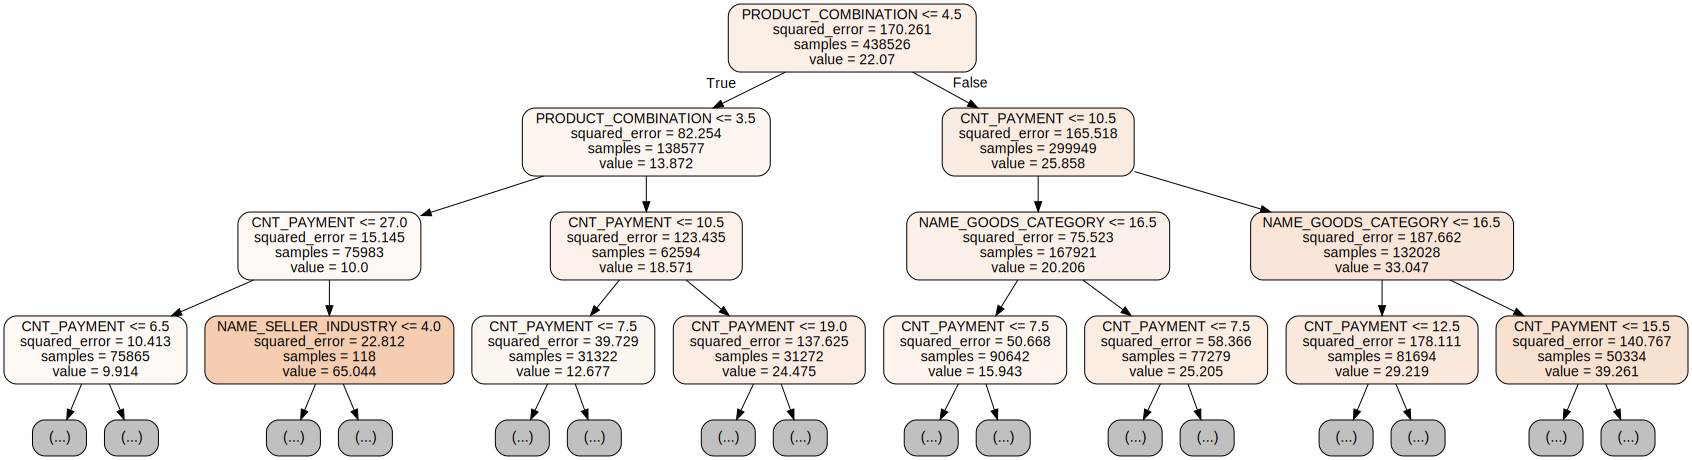

In [25]:
dot_data = export_graphviz(
    best_pipeline["model"],
    feature_names=sample_data.columns,
    max_depth=3,
    rounded=True,
    filled=True,
)
import graphviz

graph = graphviz.Source(dot_data, format="png")
graph

**Exporting the model:**

In [26]:
best_pipeline.fit(X_train.vstack(X_test), pl.concat([y_train, y_test]))
joblib.dump(best_pipeline, "deployment/app/model_files/fee_model-0.1.joblib")

['deployment/app/model_files/fee_model-0.1.joblib']

## Model Summary

* The best-performing model was a decision tree.
* The model demonstrated consistent performance across the entire target range.
* Slight variations in performance were observed based on the size of the loan.